In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input

# data display libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import matplotlib.lines as mlines
from seaborn import heatmap

## **PART 1 - preparing the data for training**




**Loading the data**

In [2]:
#preparing the data using the validation protocol,(90% train,10% validation) 
(train,validation) =tfds.load(name= 'ColorectalHistology',split=['train[:90%]','train[90%:]'],as_supervised=True,shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteYEWONH/colorectal_histology-train.tfrecord


  0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [3]:
#getting the class names
dataset = tfds.builder('ColorectalHistology')
info = dataset.info
datapoint=next(iter(train))
class_names=[]
for i in range(info.features['label'].num_classes):
  class_names.append(info.features['label'].int2str(i))

**Converting the data into keras friendly npArray**

In [4]:
x_train,y_train,x_validation,y_validation =[],[],[],[]

# Convert tensorflow dataframe to list of numpy arrays
for datapoint in tfds.as_numpy(train):
  x_train.append(datapoint[0])
  y_train.append(datapoint[1])
for datapoint in tfds.as_numpy(validation):
  x_validation.append(datapoint[0])
  y_validation.append(datapoint[1])

# List to numpy array
x_train = np.asarray(x_train)
y_train=np.asarray(y_train)
x_validation =np.asarray(x_validation)
y_validation=np.asarray(y_validation)

# **PART 2 - training the models**
**The models will be trained with transfer learing approch using a VGG19 Trained model**






## First model -a VGG like Model
- **Block1:** 32-`Conv2D` + 32-`Conv2D` +  `MaxPooling` 
- **Block2:** 64-`Conv2D` + 64-`Conv2D` +  `MaxPooling` 
- **Block3:** 128-`Conv2D` + 128-`Conv2D` +  `MaxPooling` 
- **Block4:** 512-`Dense` + `Dropout(0.5)`
- **Optimizer** - Adam
- `padding='same'` in all Conv2D layers





In [38]:
#training parameters
NUM_EPOCH = 20
BATCH_SIZE= 128
IMAGE_SHAPE = [150,150]

In [39]:
#preproceing data for better results
preprocess_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    )

#the preprocced datasets
train_iter = preprocess_datagen.flow(x_train,y_train,batch_size=BATCH_SIZE)
validation_iter = preprocess_datagen.flow(x_validation,y_validation,batch_size=BATCH_SIZE)

In [40]:
model_1 = Sequential(name="VGG-like")

# block1
model_1.add(Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(150,150,3))) 
model_1.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model_1.add(MaxPooling2D((2,2)))

# block2
model_1.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_1.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_1.add(MaxPooling2D((2,2)))

# block3
model_1.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_1.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_1.add(MaxPooling2D((2,2)))

# block4
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(8, activation='softmax'))
 
model_1.summary()

Model: "VGG-like"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 37, 37, 128)       738

In [41]:

# optimizer
opt = keras.optimizers.Adam()

# compiling the model
model_1.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_1 = model_1.fit(
    train_iter,
    validation_data= validation_iter,
    epochs=NUM_EPOCH,
    batch_size=BATCH_SIZE,
    verbose=0
    )


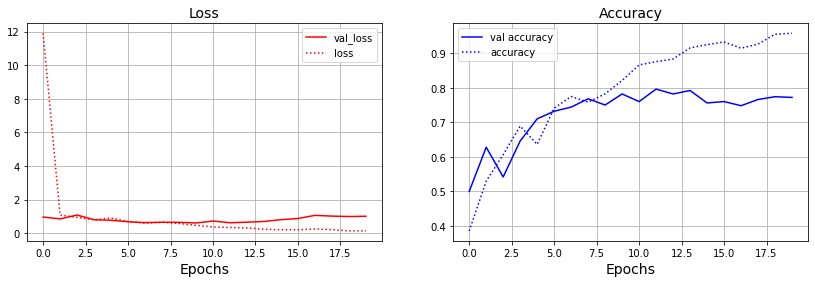

In [42]:

# trainging history
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(history_1.history['val_loss'],'r',label='val_loss')
plt.plot(history_1.history['loss'],':r',label='loss')
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid()
plt.legend()


plt.subplot(1,2,2)
plt.plot(history_1.history['val_accuracy'],'b',label='val accuracy')
plt.plot(history_1.history['accuracy'],':b',label='accuracy')
plt.title('Accuracy',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid()
plt.legend()

In [43]:
# evaluate the trained model on the test dataset
model_1.evaluate(validation_iter) 

4/4 [==============================] - 1s 139ms/step - loss: 1.0040 - accuracy: 0.7720


[1.004034161567688, 0.7720000147819519]

The model got a good score, however due to the small dataset and the discrepancy between the accuracy's sugguest overffiting, we shall try to keep the score while adressing the overfitting  

## Second model - a VGG like model with data augmentation
- **Block1:** (32-`Conv2D`+`BatchNormalization`) + (32-`Conv2D` +`BatchNormalization`) + `MaxPooling` 
- **Block2:** (64-`Conv2D`+`BatchNormalization`) + (64-`Conv2D` +`BatchNormalization`) + `MaxPooling` 
- **Block3:** (128-`Conv2D`+`BatchNormalization`) + (128-`Conv2D` +`BatchNormalization`) + `MaxPooling` 
- **Block4:** 512-`Dense` + `BatchNormalizatio` + `Dropout(0.5)`
- **Optimizer** - Adam
- `padding='same'` in all Conv2D layers


In [44]:
#training parameters
NUM_EPOCH = 30
BATCH_SIZE= 128
IMAGE_SHAPE = [150,150]

In [45]:
#ImageDataGenerator for data augmentation
augment_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=3,
    height_shift_range=3,
    horizontal_flip=True,
    vertical_flip=True
    )

#preproceing data for better results
preprocess_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    )

#the preprocced datasets
aug_train_iter = augment_datagen.flow(x_train,y_train, batch_size=BATCH_SIZE)
validation_iter = preprocess_datagen.flow(x_validation,y_validation,batch_size=BATCH_SIZE)

In [46]:
model_2 = Sequential(name='DataAugmentation')

# block1
model_2.add(Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(150,150,3))) 
model_2.add(BatchNormalization())
model_2.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2,2)))

# block2
model_2.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_2.add(BatchNormalization())
model_2.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2,2)))

# block3
model_2.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_2.add(BatchNormalization())
model_2.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2,2)))

# block4
model_2.add(Flatten())
model_2.add(Dense(512, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(Dense(8, activation='softmax'))


model_2.summary()

Model: "DataAugmentation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_28 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_29 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
batch_normalization_30 (Batc (None, 75, 75, 64)   

In [47]:
# optimizer
opt = keras.optimizers.Adam()

# compile the model
model_2.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train the model
history_2 = model_2.fit(
    aug_train_iter,
    validation_data= validation_iter,
    epochs=NUM_EPOCH,
    batch_size=BATCH_SIZE,
    verbose=0
    )

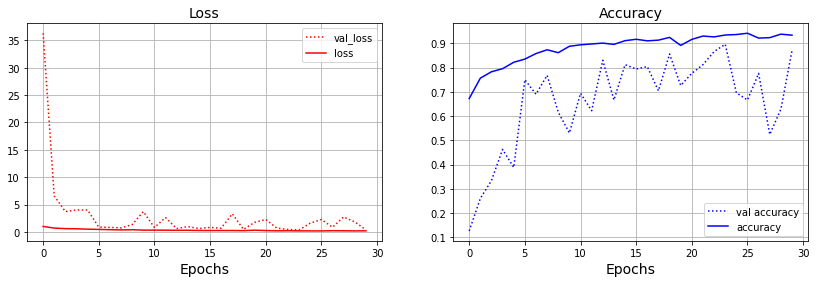

In [48]:
# training history
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(history_2.history['val_loss'],':r',label='val_loss')
plt.plot(history_2.history['loss'],'r',label='loss')
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_2.history['val_accuracy'],':b',label='val accuracy')
plt.plot(history_2.history['accuracy'],'b',label='accuracy')
plt.title('Accuracy',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid()
plt.legend()

In [49]:
# evaluate the trained model on the test dataset
model_2.evaluate(validation_iter)

4/4 [==============================] - 1s 163ms/step - loss: 0.3683 - accuracy: 0.8700


[0.3683096766471863, 0.8700000047683716]

The score is good but the accuracy/loss discrepancy is still large, the model is still overfitted

## Third model - a transfered/fine-tuned model with data augmentation
- **The Model** - a pre-trained VGG model without the "top"
- **New top**:
- 512-`Dense` + `Dropout(0.5)`
- 256-`Dense` + `Dropout(0.5)`
- **Optimizer**:
- `RMSPOP` base
- `SGD` top

- with data augmentation to increase sample size

In [ ]:
#training parameters
NUM_EPOCH = 20
BATCH_SIZE= 128
IMAGE_SHAPE = [150,150]

In [ ]:
#ImageDataGenerator for data augmentation
augment_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=3,
    height_shift_range=3,
    horizontal_flip=True,
    vertical_flip=True
    )


#preproceing data for better results
preprocess_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    )

#the preprocced datasets
aug_train_iter = augment_datagen.flow(x_train,y_train, batch_size=BATCH_SIZE)
validation_iter = preprocess_datagen.flow(x_validation,y_validation,batch_size=BATCH_SIZE)

In [ ]:
vgg_3 = VGG16(
    input_shape=IMAGE_SHAPE+[3],
    include_top=False,
    weights='imagenet')
vgg_3.trainable=False

model_3 = Sequential()
model_3.add(vgg_3)
model_3.add(Flatten())
model_3.add(Dense(512,activation="relu"))
model_3.add(Dropout(0.5))
model_3.add(Dense(256, activation="relu"))
model_3.add(Dropout(0.5))
model_3.add(Dense(8, activation="softmax"))

model_3.summary()  

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________

In [ ]:
# optimizer
opt = keras.optimizers.RMSprop()

model_3.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_3 = model_3.fit(
    aug_train_iter,
    validation_data= validation_iter,
    epochs=NUM_EPOCH,
    batch_size=BATCH_SIZE,
    verbose=0
    )

In [ ]:
model_3.trainable=True
opt = keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9,nesterov=True)
model_3.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_3.summary()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 2

In [ ]:
history_3 = model_3.fit(
    aug_train_iter,
    validation_data= validation_iter,
    epochs=NUM_EPOCH,
    batch_size=BATCH_SIZE,
    verbose=0
    )

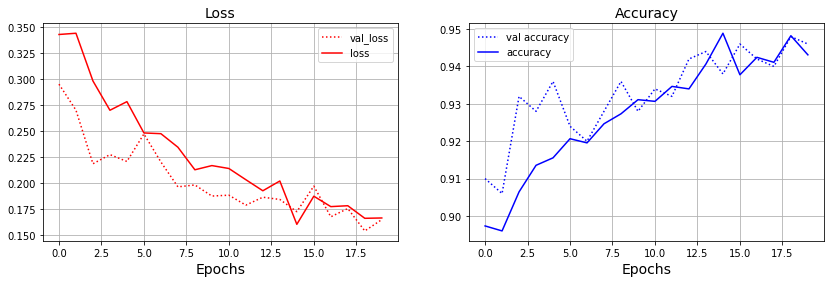

In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(history_3.history['val_loss'],':r',label='val_loss')
plt.plot(history_3.history['loss'],'r',label='loss')
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_3.history['val_accuracy'],':b',label='val accuracy')
plt.plot(history_3.history['accuracy'],'b',label='accuracy')
plt.title('Accuracy',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid()
plt.legend()

In [ ]:
model_3.evaluate(validation_iter) # evaluate the trained model on the test dataset

4/4 [==============================] - 1s 276ms/step - loss: 0.1649 - accuracy: 0.9460


[0.16493940353393555, 0.9459999799728394]

The model got a high score and the accuracy/loss is close to the val_accuracy/loss, minimum overfitting

## Comparing the models

---



<table>
  <tr>
    <th>Model</th>
    <th>#Parameters</th>
    <th>Optimizers</th>
    <th>batch-size</th>
    <th>epochs</th>
    <th>accuracy</th>
  </tr>
    
  <!-- copy this block once for every model you tested -->  
  <tr> 
    <td>VGG-like</td>   <!-- Model -->
    <td>  21,525,288 </td> <!-- #parameters -->
    <td>  Adam </td> <!-- Optimizers -->
    <td>64</td> <!-- batch-size -->
    <td>20</td> <!-- epochs -->
    <td>0.7720</td> <!-- accuracy -->
  </tr>
    
   <tr> 
    <td>VGG-like+data augemntation</td>   <!-- Model -->
    <td>  21,529,128 </td> <!-- #parameters -->
    <td>  Adam</td> <!-- Optimizers -->
    <td>128</td> <!-- batch-size -->
    <td>30</td> <!-- epochs -->
    <td>0.8700</td> <!-- accuracy -->
  </tr>  
    
   <tr> 
    <td>VGG16 transfer/fine tune </td>   <!-- Model -->
    <td>  19,042,888 </td> <!-- #parameters -->
    <td>  RMSPOP, SGD </td> <!-- Optimizers -->
    <td>128</td> <!-- batch-size -->
    <td>20</td> <!-- epochs -->
    <td>0.9459</td> <!-- accuracy -->
  </tr>      
    
     
</table>


Model 3 is the optimal model, high accuracy and minimal overfitting

In [ ]:
#model_3 is the optimal model
model=model_3

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


# **PART 3 - Feature Visualization**


**Confusion matrix**

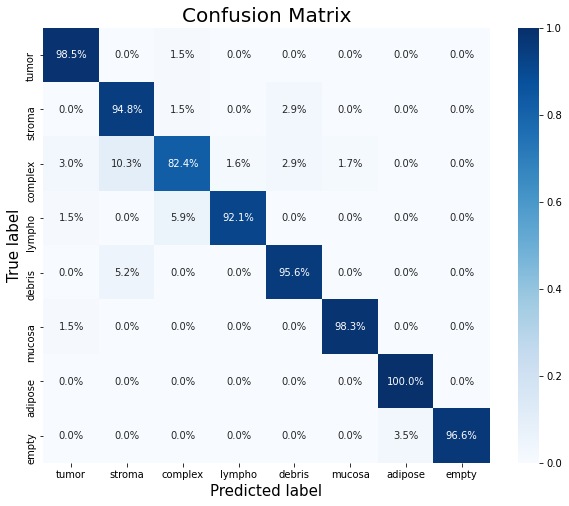

In [ ]:
#getting predictions
yhat_1hot = model.predict(preprocess_input(x_validation))
yhat = np.argmax(yhat_1hot, axis=1)

#calculationg the matrix
CM = confusion_matrix(y_validation, yhat)
CM=CM/CM.sum(axis=1)
#visualzing
plt.figure(figsize=(10,8))
heatmap(CM,xticklabels=class_names,yticklabels=class_names,cmap='Blues',annot=True,fmt='.1%')
plt.title("Confusion Matrix",fontsize=20)
plt.xlabel('Predicted label', fontsize=15)
plt.ylabel('True label', fontsize=15)
plt.show()

**Feature extraction**

In [ ]:
#Extracting the features from 2 FC layer
features_extractor = keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
features_8192D = features_extractor.predict(preprocess_input(x_validation))

#using t-SNE algorithm reduce the dimention to 2-D
features_2D =TSNE(n_components=2).fit_transform(features_8192D)

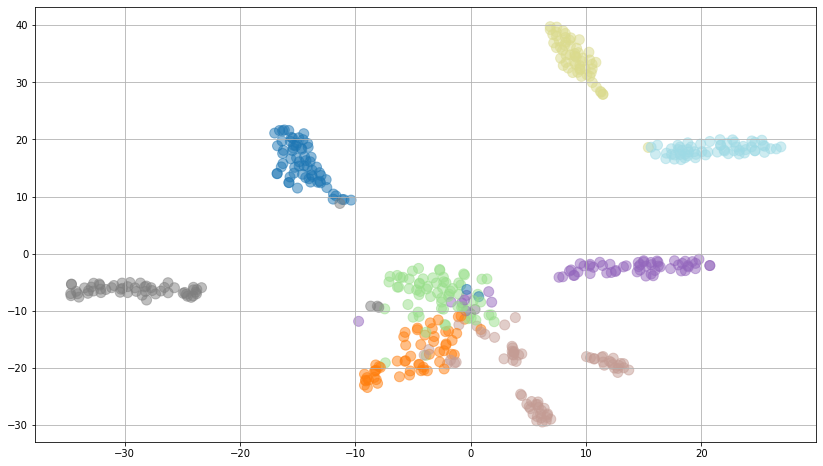

In [ ]:
##visualzing the features
plt.figure(figsize=(14,8))
plt.scatter(features_2D[:,1], features_2D[:,0],c=y_validation, s=100,  
            cmap='tab20', alpha=0.5)

plt.grid()
plt.show()

# **PART 4-testing the trained model**

**Loading the data**

In [ ]:
#loading the large image dataset
test_large =tfds.load(name='ColorectalHistologyLarge',split=['test'])

**Converting the data into keras friendly npArray**

In [ ]:
large_dataset = []

# Convert tensorflow dataframe to list of numpy arrays
for entry in tfds.as_numpy(test_large[0]):
    large_dataset.append(entry)

# List to numpy array
large_dataset = np.asarray(large_dataset)

**Help functions**

In [ ]:
#A function that takes (150,150) images, classifies the image and colors it, returns the colored image
def classify_and_color(img):
    pred=model.predict(img[None])
    y_pred=np.argmax(pred)
    if(y_pred == 0):
      img[:,:,0]=255
      img[:,:,1]=128
      img[:,:,2]=0
    elif(y_pred == 1):
      img[:,:,0]=0
      img[:,:,1]=153
      img[:,:,2]=0
    elif(y_pred == 2):
      img[:,:,0]=204
      img[:,:,1]=204
      img[:,:,2]=0
    elif(y_pred == 3):
      img[:,:,0]=0
      img[:,:,1]=128
      img[:,:,2]=255   
    elif(y_pred == 4):
      img[:,:,0]=153
      img[:,:,1]=0
      img[:,:,2]=153 
    elif(y_pred == 5):
      img[:,:,0]=255
      img[:,:,1]=229
      img[:,:,2]=204
    elif(y_pred == 6):
      img[:,:,0]=160
      img[:,:,1]=160
      img[:,:,2]=160
    elif(y_pred == 7):
      img[:,:,0]=0
      img[:,:,1]=0
      img[:,:,2]=0
    return img

#a function that returns the probability of a tumor in the image
def heatmap_classification(img):
  pred=model.predict(img[None])
  return pred[0][0]


**Coloring the image based on predictions and extracting the probability heatmap**

In [ ]:
classified_images=[]
classified_heatmap=[]
for i in range(10):

  #blank(5000,5000) image as the "canvas"
  image=np.zeros((5000,5000,3), dtype=np.uint8)
  #the heatmap to fill
  heat_map=np.zeros((66,66))
  h_row=-1
  for row in range(0,4950,75):

    #rows and cols for the heatmap
    h_row+=1
    h_col=-1
    for col in range(0,4950,75):

      if(row==4875):
        row=4850
      if(col==4875):
        col=4850
      h_col+=1  

      #slicing the images into  (150,150) segments, with a 50% overlap  
      sliced_image = large_dataset[i]['image'][row:150+row,col:150+col].copy()
      sliced_image = preprocess_input(sliced_image)

      #coloring the canvas  
      image[0+row:150+row,0+col:150+col]=classify_and_color(sliced_image.copy())

      #creating the heatmap
      heat_map[h_row][h_col]=heatmap_classification(sliced_image)
 
  classified_images.append(image)
  classified_heatmap.append(heat_map)  

In [ ]:
orange = mlines.Line2D([], [], color='orange', marker='s',linestyle='None',
                  markersize=15, label='Tumor epithelium')
green= mlines.Line2D([], [], color='green', marker='s',linestyle='None',
                  markersize=15, label='Stroma(simple)')
yellow= mlines.Line2D([], [], color='yellow', marker='s',linestyle='None',
                  markersize=15, label='Stroma(complex)')
blue= mlines.Line2D([], [], color='blue', marker='s',linestyle='None',
                  markersize=15, label='Immune cells')
purple= mlines.Line2D([], [], color='purple', marker='s',linestyle='None',
                  markersize=15, label='Debris or mucus')
pink= mlines.Line2D([], [], color='pink', marker='s',linestyle='None',
                  markersize=15, label='Mucosal glands')
gray= mlines.Line2D([], [], color='gray', marker='s',linestyle='None',
                  markersize=15, label='Adipose tissue')
black=mlines.Line2D([], [], color='black', marker='s',linestyle='None',
                  markersize=15, label='Background')

lines = [black, gray,pink,purple,blue,yellow,green,orange]
labels = [line.get_label() for line in lines]

**Display the images side by side**

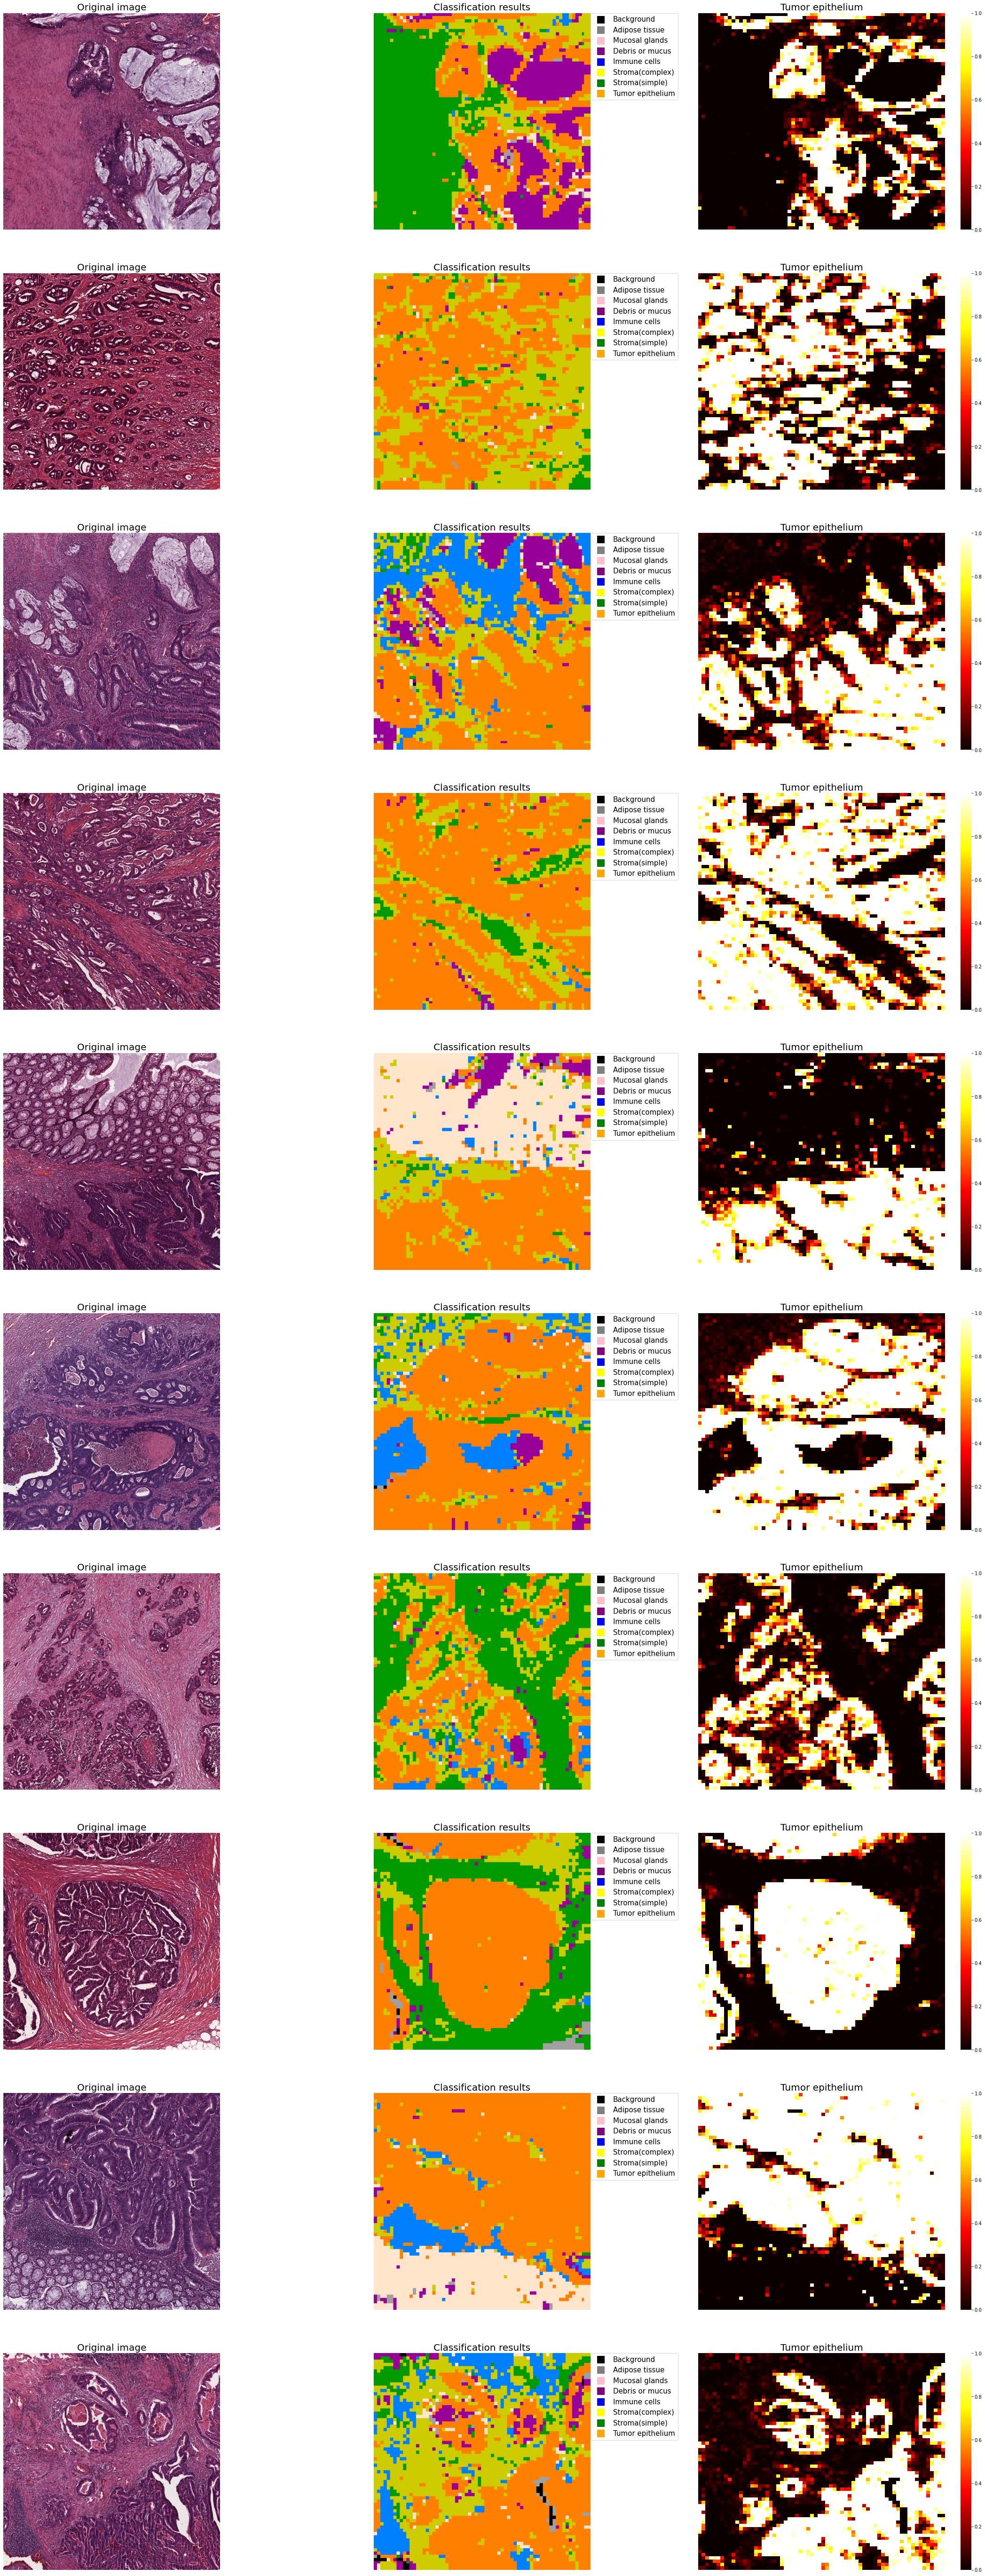

In [ ]:
plt.figure(figsize=(40,100))
place=1           
for i in range(10):
    plt.subplot(10,3,place)
    plt.title("Original image",fontsize=20)
    plt.imshow(large_dataset[i]['image'])
    plt.axis('off')
    place+=1

    plt.subplot(10,3,place)
    plt.title("Classification results",fontsize=20)
    plt.imshow(classified_images[i])
    plt.axis('off')
    plt.legend(lines, labels,bbox_to_anchor=(1, 1), loc='upper left',fontsize=15, borderaxespad=0.)
    place+=1

    plt.subplot(10,3,place)
    plt.title("Tumor epithelium",fontsize=20)
    heatmap(classified_heatmap[i],cmap='hot')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    place+=1